<a href="https://colab.research.google.com/github/denncraft/AI_ML_notes/blob/main/Deep_Learning_2023_chapter_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##набор данных IMDB

содержит 50000 отзывов по фильмам, 25000 обучающих и 25000 конгтрольных

In [78]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb

# для повторяемости результатов при перезапусках или для сравнения результатов с различными настройками
keras.utils.set_random_seed = 123

In [79]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

каждое слово кажого отзыва о фильме было проиндексировано и занесено в словарь, а словать отсортирован по количеству использования каждого слов
`num_words` ограничивает количество слов из словаря выборкой наиболее употребимых слов, таким образом, что все слова имеющие индекс со значением больше указанного заменяются на 2

In [80]:
len(train_data[0])

218

In [81]:
max([max(sequence) for sequence in train_data])

9999

декодирование отзыва о фильме из вектора чисел в текст

In [82]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i-3, '^') for i in train_data[0]]
)


In [83]:
decoded_review

"^ this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ^ is an amazing actor and now the same being director ^ father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ^ and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ^ to the two little boy's that played the ^ of norman and paul they were just brilliant children are often left out of the ^ list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

нельзя просто передать списки чисел непосредственно в нейронную сеть, все они имеют раную длину, а нейронная сеть ожидает получить согласованные пакеты данных

существует два пути нормализации данных
1. привести все списки к одинковой длине, преобразовав в тензоры с формой (количество отзывов, максимальная длина отзыва) после чего передав такие ЦЕЛОЧИСЛЕННЫЕ тензоры в слой `Embedding`

2. выполнить `прямое кодирование` списков в векторы состоящие из 0 и 1 для слов в позициях их индексов из словаря. это может означать, что если мы используем только 10000 самых употребимых слов, то наш тензор будет иметь форму (количество отзывов, 10000). такой набор тензоров можно передать в слой `Dense`

здесь на ум приходит идея преобразования массива слов каждого отзыва из одномерного в двумерный, где для каждого слова будет вычислено количество его повторений в отзыве, после чего каждому уникальному слову будет присвоено значение его "влияния", в зависимости от количества его повторений, сумма всех значения "влияния" должна быть равна 1.

In [84]:
max([len(sequence) for sequence in train_data])

2494

мы будем использовать прямое кодирование


для начала создадим тензор с формой  (количество отзывов, 10000)
точка нужна, чтобы явно указать, что числа должны быть "float32"


In [85]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i,j] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [86]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Наблюдение: не учитывается количество повторений одного слова в одном отзыв, т.к. индекс у этого слов один.
например, в отзыве с индексом 0 всего 218 слов, включая замененные при загрузке, а после нормализации этого отзыва, количество единиц в нем составило 120, что на 98 меньше, чем было изначально.
как мне кажеться это может влиять на качество предсказания.

In [87]:
len(train_data[0]) - sum(x_train[0])

98.0

нормализуем также значения таргетов

In [88]:
y_train = np.asarray(train_labels).astype("float32")
y_test  = np.asarray(test_labels).astype("float32")

определяем модель:

3 слоя Dense, 2 из которых по 16 нейронов, а последний 1 -указывающий на 0 или 1

In [89]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1,  activation="sigmoid")
])

для задач классификации с одним выходным нейроном и функцией активации - сигмоида для функции потерь предпочтительнее использования `binary_crossentropy`, но можно и `mean_squared_error`.

для оптимизатора в большинстве задач выбирается `rmsprop`

а контролировать будем `accuracy`

In [90]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

создание проверочного набора

In [91]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

обучение модели с сохранением истории

In [92]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=6,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/6
30/30 [==============================] - 3s 72ms/step - loss: 0.5338 - accuracy: 0.7767 - val_loss: 0.4060 - val_accuracy: 0.8629
Epoch 2/6
30/30 [==============================] - 1s 35ms/step - loss: 0.3336 - accuracy: 0.8890 - val_loss: 0.3514 - val_accuracy: 0.8596
Epoch 3/6
30/30 [==============================] - 1s 33ms/step - loss: 0.2516 - accuracy: 0.9161 - val_loss: 0.3049 - val_accuracy: 0.8769
Epoch 4/6
30/30 [==============================] - 1s 34ms/step - loss: 0.2014 - accuracy: 0.9316 - val_loss: 0.2837 - val_accuracy: 0.8860
Epoch 5/6
30/30 [==============================] - 1s 33ms/step - loss: 0.1687 - accuracy: 0.9455 - val_loss: 0.3147 - val_accuracy: 0.8749
Epoch 6/6
30/30 [==============================] - 1s 38ms/step - loss: 0.1426 - accuracy: 0.9549 - val_loss: 0.3182 - val_accuracy: 0.8753


посмотрим что в объекте history

In [93]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

построим график отношения потерь к количеству выпаолняемых эпох

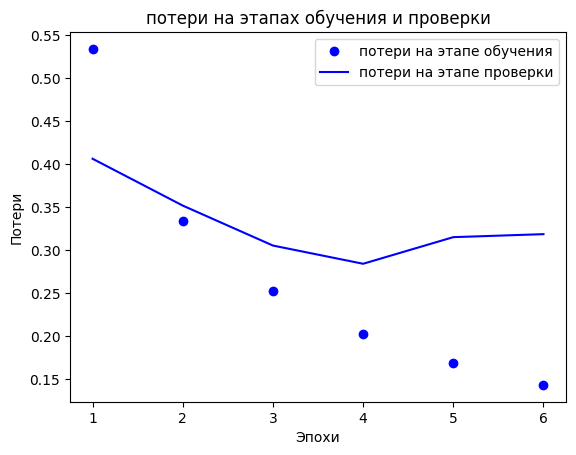

In [94]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, "bo", label="потери на этапе обучения")
plt.plot(epochs, val_loss_values, "b", label="потери на этапе проверки")
plt.title("потери на этапах обучения и проверки")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()